In [174]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from keras.optimizers import Adadelta, Adam, SGD
from keras.losses import sparse_categorical_crossentropy
from keras.regularizers import l1
from keras.backend import clear_session
from keras.callbacks import TensorBoard
from keras.initializers import glorot_normal
from keras.preprocessing.image import ImageDataGenerator

In [178]:
df = pd.read_csv(r'C:\Users\marno\ibs\GreenfoxIBS\Deep Learning Home Assignment\Data\groundtruth.tsv', sep='\t')
images = 'C://Users//marno//ibs//GreenfoxIBS//Deep Learning Home Assignment//Data//imgs//'

## The groundtruth.tsv labels

#### The (tab-delimited) groundtruth.tsv file has 4 columns:


* **user_id:** (string) Participant's ID.

* **ad_clicked:** (int) Whether the participant clicked on the ad (1) or not (0).

* **attention:** (int) Self-reported attention score, in 1-5 Likert-type scale (1 denotes no attention).

* **log_id:** (string) Mouse tracking log ID.

In [156]:
df.head()

,user_id,ad_clicked,attention,log_id
0,5npsk114ba8hfbj4jr3lt8jhf5,0,4,20181002033126
1,5o9js8slc8rg2a8mo5p3r93qm0,1,5,20181001211223
2,pi17qjfqmnhpsiahbumcsdq0r6,0,4,20181001170952
3,3rptg9g7l83imkbdsu2miignv7,0,1,20181001140754
4,049onniafv6fe4e6q42k6nq1n2,0,1,20181001132434


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     2909 non-null   object
 1   ad_clicked  2909 non-null   int64 
 2   attention   2909 non-null   int64 
 3   log_id      2909 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 91.0+ KB


In [179]:
img_files =[]
# make an array of the file names in imgs folder without .png extension
for file in os.listdir(images):
    img_files.append(file[:-4])

# conver df log_id to str
df['log_id'] = df['log_id'].astype(str)

In [180]:
# filter df to contain only the images that are in the imgs folder
df = df[df['log_id'].isin(img_files)]

In [165]:
# resize images to 224x224
def resize_img(img):
    img = load_img(
        img, 
        target_size=(224,224),
        color_mode='rgb',
        keep_aspect_ratio=False
    )
    # return image path
    


In [166]:

# Apply preprocessing to all images if df['log_id'] is in img_files
df['image'] = df['log_id'].apply(lambda x: resize_img(images + x + '.png'))


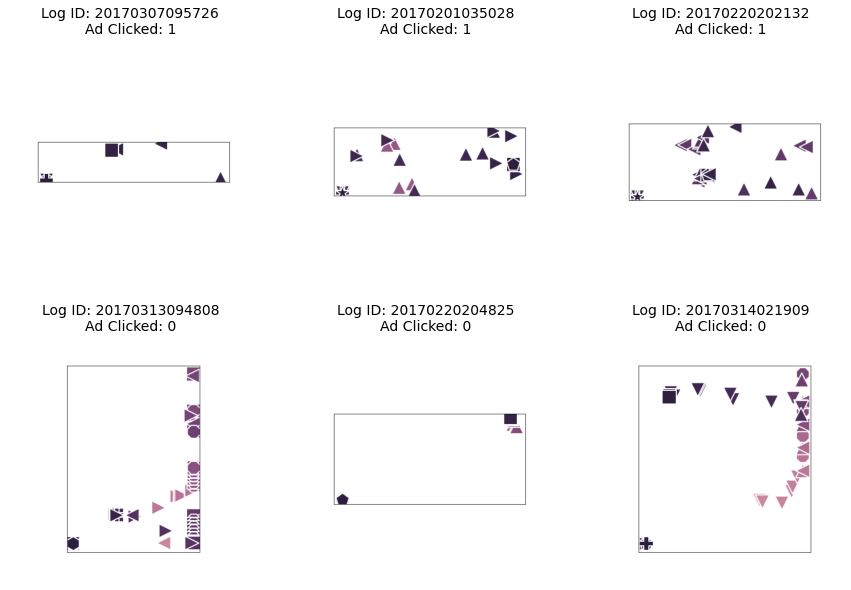

In [182]:

# Assuming 'images' is the path to the folder containing your images

plt.figure(figsize=(15, 10))
clicked_images = df[df['ad_clicked'] == 1].sample(3, random_state=42)
not_clicked_images = df[df['ad_clicked'] == 0].sample(3, random_state=42)

for i, (index, row) in enumerate(pd.concat([clicked_images, not_clicked_images]).iterrows(), 1):
    plt.subplot(2, 3, i)
    img_path = os.path.join(images, str(row['log_id']) + '.png')
    img = plt.imread(img_path)
    
    plt.imshow(img)
    plt.title(f"Log ID: {row['log_id']}\nAd Clicked: {row['ad_clicked']}", fontsize=14)
    plt.axis('off')

plt.show()

In [141]:
# Convert labels to numpy array
labels = np.array(df['ad_clicked'])

In [193]:
# Add column to df with image paths
df['image_path'] = images + df['log_id'] + '.png'

In [194]:
#df to new csv
df.to_csv('groundtruth_with_images.csv', index=False)      

In [203]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame with 'image', and 'ad_clicked' columns

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert numerical labels to strings
train_df['ad_clicked'] = train_df['ad_clicked'].astype(str)
val_df['ad_clicked'] = val_df['ad_clicked'].astype(str)
test_df['ad_clicked'] = test_df['ad_clicked'].astype(str)

# ImageDataGenerator for rescaling and resizing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Use validation_split to specify the split for validation data

# Flow from DataFrame for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=images,  # Path to the folder containing images
    x_col='image_path',  # Column containing image filenames 
    y_col='ad_clicked',  # Column containing labels
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification
    shuffle=True,
    seed=42,
    subset='training'  # Specify training subset
)

# Flow from DataFrame for validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,  # Use the same DataFrame as training, as it uses the 'subset' parameter
    directory='imgs',
    x_col='image_path',
    y_col='ad_clicked',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=42,
    subset='validation'  # Specify validation subset
)

# Flow from DataFrame for testing data
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='imgs',
    x_col='image_path',
    y_col='ad_clicked',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 903 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.
Found 353 validated image filenames belonging to 2 classes.


In [206]:
# Create keras cnn model with resnet50 architecture 
from keras import layers
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.regularizers import l1
from keras.backend import clear_session
from keras.callbacks import TensorBoard 
from keras.initializers import glorot_normal
from keras.layers import MaxPooling2D

def create_model():
    model = keras.Sequential()
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    
    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Optional dropout for regularization

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification: Clicked or Not Clicked
        
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


model = create_model()

In [207]:
# Create TensorBoard callback
tensorboard = TensorBoard(log_dir='logs')

# Fit the model with TensorBoard callback
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tensorboard]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate_generator(
    generator=test_generator,
    steps=len(test_generator)
)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



C:\Users\marno\AppData\Local\Temp\ipykernel_10136\3696261033.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
29/29 [==============================] - 47s 2s/step - loss: 0.7590 - accuracy: 0.7254 - val_loss: 0.6325 - val_accuracy: 0.6711
Epoch 2/10
29/29 [==============================] - 47s 2s/step - loss: 0.5842 - accuracy: 0.7386 - val_loss: 0.5845 - val_accuracy: 0.6711
Epoch 3/10
29/29 [==============================] - 46s 2s/step - loss: 0.5198 - accuracy: 0.7364 - val_loss: 0.5676 - val_accuracy: 0.6711
Epoch 4/10
29/29 [==============================] - 44s 2s/step - loss: 0.5190 - accuracy: 0.7685 - val_loss: 0.5691 - val_accuracy: 0.6889
Epoch 5/10
29/29 [==============================] - 48s 2s/step - loss: 0.5011 - accuracy: 0.7564 - val_loss: 0.6391 - val_accuracy: 0.6933
Epoch 6/10
29/29 [==============================] - 46s 2s/step - loss: 0.4573 - accuracy: 0.7841 - val_loss: 0.5973 - val_accuracy: 0.7156
Epoch 7/10
29/29 [==============================] - 43s 1s/step - loss: 0.4493 - accuracy: 0.7951 - val_loss: 0.5935 - val_accuracy: 0.7111
Epoch 8/10
29/29 [==

C:\Users\marno\AppData\Local\Temp\ipykernel_10136\3696261033.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(


Test Loss: 0.7499
Test Accuracy: 73.65%


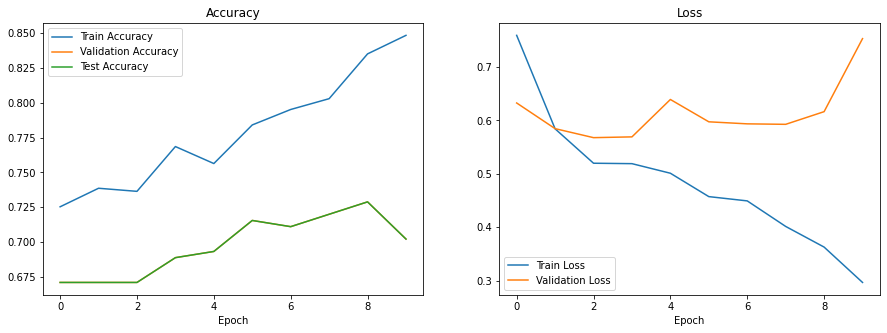

In [213]:
# Show model history 
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    
    

    plt.show()
    
plot_history(history)